In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse

## Single Model Debiasing Sanity Check

When debiasing a single predictor which just predicts the label mean and when predicting 3 features, should run for 3 rounds (conditioning on policy equal to (1,0,0), (0,1,0), and (0,0,1) in each round respectively), then since bias will be 0 on each conditioning event, should halt, and return the original predictor. 

When debiasing on a predictor which predicts correct thing in first coordinate and 0 elsewhere, no changes to model should be made on the first coordinate. In the other two coordinates, it will change to predict label mean on the subsets determined by the initial policy after the first three rounds.

In [10]:
import debiasedModel
importlib.reload(debiasedModel)

import policies
import importlib 
importlib.reload(policies)

#this data is garbage but making just to have something to test the whole process with
n_rows = 5
n_features = 3
pred_dim = n_features 

xs = np.random.normal(size=(n_rows, n_features))
slopes = np.random.uniform(size = n_features)
errs = np.random.normal(scale=0.01, size = (n_rows, n_features))
ys = np.multiply(xs, slopes) + errs

# just predicts label mean
def h1(xs):
    # calculate label mean and duplicate it for each of xs
    return np.tile(np.average(ys, axis=0), (len(xs),1))
    

# second model predicts correct linear relationship for first stock and 0 everywhere else
def h2(xs):
    # build prediction 
    preds = np.zeros((len(xs), n_features))
    preds[:,0] = ys[:,0]
    return preds

simplex = policies.Simplex(pred_dim)

init_model = h1
max_depth = 10
policy = simplex

model = debiasedModel.Debiased_model()
model.debias(xs, ys, init_model, max_depth, policy);
model.training_preds[0] == np.mean(ys, axis=0)

init_model = h2

model = debiasedModel.Debiased_model()
model.debias(xs, ys, init_model, max_depth, policy);
model.training_preds;



Round of debiasing: 
012
Model debiasing complete, halting early after round 3/10.
Round of debiasing: 
012345
Model debiasing complete, halting early after round 6/10.


We can plot the MSE dropping with every round of update:

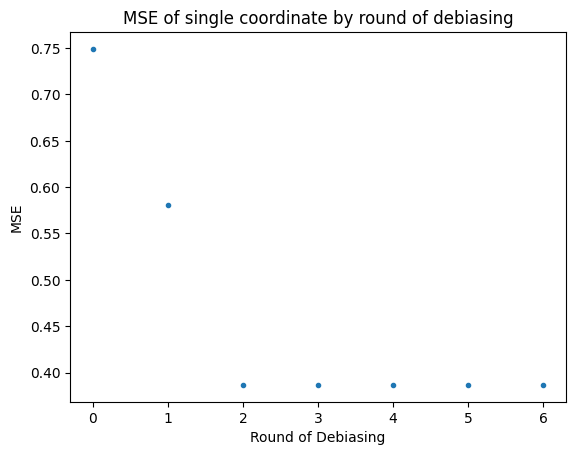

In [21]:
mses = np.zeros((model.depth+1, model.prediction_dim))
for i in range(len(model.training_preds)):
    mses[i] = mse(ys, model.training_preds[i], multioutput='raw_values')

coord = 1
plt.plot(np.arange(model.depth+1), mses[:,coord], '.')
plt.title("MSE of single coordinate by round of debiasing")
plt.xlabel("Round of Debiasing")
plt.ylabel("MSE");

We can also visualize the revenue of the policy after each update:

[0.00546942 0.00546942 0.02979028]
[-0.38856487 -0.38856487  0.02979028]


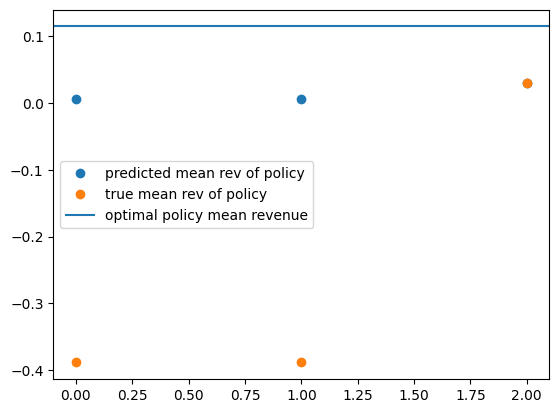

In [54]:

# simplex.run(model.training_preds[0])

# predicted revenue of each point per round
pred_rev = np.mean([np.einsum('ij,ij->i', model.training_preds[i], simplex.run(model.training_preds[i])) for i in range(3)], axis=1)#fancy vectorized row-wise dot product 

# actual revenue per round per point
true_rev = np.mean([np.einsum('ij,ij->i', ys, simplex.run(model.training_preds[i])) for i in range(3)], axis=1)

print(pred_rev)
print(true_rev)

plt.plot(np.arange(3), pred_rev, 'o', label="predicted mean rev of policy")
plt.plot(np.arange(3), true_rev, 'o', label="true mean rev of policy")
plt.axhline(np.mean(np.einsum('ij,ij->i', ys, simplex.run(ys))), label="optimal policy mean revenue")
plt.legend()


# Second Sanity Check: Running on fully worked-through example

Consider an extremely simple dataset, with only 3 datapoints, constructed so that we can easily hand-check the debiasing process.

In [3]:
importlib.reload(debiasedModel)

xs = np.array([[1],[2],[3]]) 
ys = np.array([[1,10], [1,0], [1,0]])

def h(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append([5,10])
        if x==2:
            preds.append([1,0])
        if x==3:
            preds.append([9,0])
    return np.array(preds)

max_depth = 8
pred_dim = 2
simp = policies.Simplex(pred_dim)
model = debiasedModel.Debiased_model()
model.debias(xs, ys, h, max_depth, simp);

Round of debiasing: 
012345
Model debiasing complete, halting early after round 6/8.


Debiasing on this should proceed as follows: On the first round, it will subset on the points where the policy chooses (1,0), which corresponds to the second two xs. It will then calculate the bias on these, which is (4,0). Here, we see that it has indeed chosen the correct two points to bucket, recorded their bias term correctly.

It should then create a new model, which predicts the same as the original model, but with an offset of (4,0) for these two points, which it does:

In [4]:
print("Coordinate being debiased:", model.debiasing_cond[0])
print("Points where value is 1 for this coordinate:", model.training_buckets_indices[0][0])
print("Bias on this subset of points: ", model.bias_array[0])
print("Original predictions:")
print(model.training_preds[0])
print("Updated predictions:")
print(model.training_preds[1])

Coordinate being debiased: 0
Points where value is 1 for this coordinate: [1 2]
Bias on this subset of points:  [[4. 0.]]
Original predictions:
[[ 5 10]
 [ 1  0]
 [ 9  0]]
Updated predictions:
[[ 5 10]
 [-3  0]
 [ 5  0]]


Next, it will look at the subset of points where this new updated model's policy chooses (0,1). This should correspond to the first two points. This update shouldn't do anything, because the updated model is unbiased on these two points.

In [5]:
print("Coordinate being debiased:", model.debiasing_cond[1])
print("Points where value is 1 for this coordinate:", model.training_buckets_indices[1][0])
print("Bias on this subset of points: ", model.bias_array[1])
print("Previous predictions:")
print(model.training_preds[1])
print("Updated predictions:")
print(model.training_preds[2])

Coordinate being debiased: 1
Points where value is 1 for this coordinate: [0 1]
Bias on this subset of points:  [[0. 0.]]
Previous predictions:
[[ 5 10]
 [-3  0]
 [ 5  0]]
Updated predictions:
[[ 5 10]
 [-3  0]
 [ 5  0]]


Now, it will recurse back to check on the points where the model chooses (1,0). This corresponds to the last (third) point, and the model *is* biased on these, with bias (4,0), so it will correct itself.

In [6]:
print("Coordinate being debiased:", model.debiasing_cond[2])
print("Points where value is 1 for this coordinate:", model.training_buckets_indices[2][0])
print("Bias on this subset of points: ", model.bias_array[2])
print("Previous predictions:")
print(model.training_preds[2])
print("Updated predictions:")
print(model.training_preds[3])

Coordinate being debiased: 0
Points where value is 1 for this coordinate: [2]
Bias on this subset of points:  [[4. 0.]]
Previous predictions:
[[ 5 10]
 [-3  0]
 [ 5  0]]
Updated predictions:
[[ 5 10]
 [-3  0]
 [ 1  0]]


The model is now unbiased conditional on both the places where the policy chooses (0,1) and where it chooses (1,0). It has to loop one more time through both (0,1) and (1,0), and will halt after this, with a total of 6 rounds.

In [7]:
model.depth

6

We expect to see the MSE drop in every single round on the training data.

In [8]:
preds = np.array(model.training_preds)
for i in range(len(model.training_preds)):
    print(mse(ys, model.training_preds[i], multioutput='raw_values'))


[26.66666667  0.        ]
[16.  0.]
[16.  0.]
[10.66666667  0.        ]
[10.66666667  0.        ]
[10.66666667  0.        ]
[10.66666667  0.        ]


# Running on a terrible model

Starting with a model that just randomly guesses on data where labels have linear relationship with features., let's see how debiasing does.

Round of debiasing: 
0123
[[0.37454012 0.95071431 0.73199394]
 [0.59865848 0.15601864 0.15599452]
 [0.05808361 0.86617615 0.60111501]]
[[0.46865848 0.15601864 0.14599452]]
[array([1])]

[[0.37454012 0.95071431 0.73199394]
 [0.13       0.         0.01      ]
 [0.05808361 0.86617615 0.60111501]]
[[-0.05868813  0.50344523  0.43155448]]
[array([0, 2])]

[[0.43322825 0.44726908 0.30043947]
 [0.13       0.         0.01      ]
 [0.11677175 0.36273092 0.16956053]]
[[0. 0. 0.]]
[array([], dtype=int64)]

[[0.43322825 0.44726908 0.30043947]
 [0.13       0.         0.01      ]
 [0.11677175 0.36273092 0.16956053]]
[[0.00000000e+00 0.00000000e+00 8.67361738e-18]]
[array([1])]


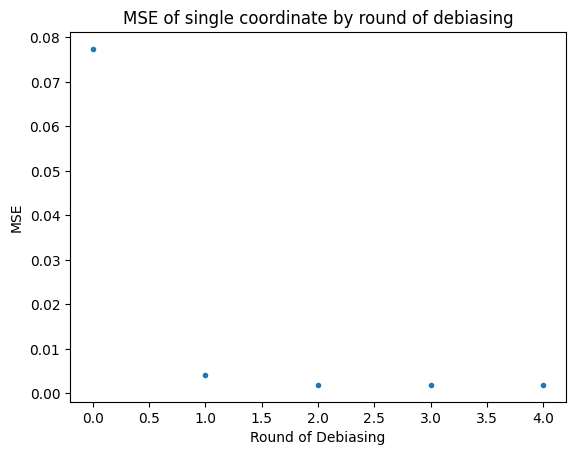

In [9]:
xs = np.array([[1],[2],[3]]) 
ys = np.array([[0.38, 0.11, 0.17], [0.13,0,0.01], [0.17,0.7, 0.3]])
pred_dim = 3

np.random.seed(42)
seeded_rand = np.random.rand(len(xs),3)
def h(xs):
    preds = []
    for x in xs:
        if x==1:
            preds.append(seeded_rand[0])
        if x==2:
            preds.append(seeded_rand[1])
        if x==3:
            preds.append(seeded_rand[2])
    return np.array(preds)

X_train = xs
Y_train = ys
init_model = h
max_depth = 4

simplex = policies.Simplex(pred_dim)
model = debiasedModel.Debiased_model()
model.debias(X_train, Y_train, init_model, max_depth, simplex);

preds = np.array(model.training_preds)

for i in range(max_depth):
    print()
    print(preds[i])
    print(model.bias_array[i])
    print(model.training_buckets_indices[i])

mses = np.zeros((model.depth+1, model.prediction_dim))
for i in range(len(model.training_preds)):
    mses[i] = mse(Y_train, model.training_preds[i], multioutput='raw_values')

coord = 0
plt.plot(np.arange(model.depth+1), mses[:,coord], '.')
plt.title("MSE of single coordinate by round of debiasing")
plt.xlabel("Round of Debiasing")
plt.ylabel("MSE");



# Debiasing conditioned on another policy

We have two models, $h_1$, and $h_2$. We would like to debias $h_1$ with respect to the policy decisions of $h_2$.

Round of debiasing: 
012345678
Model debiasing complete, halting early after round 9/10.


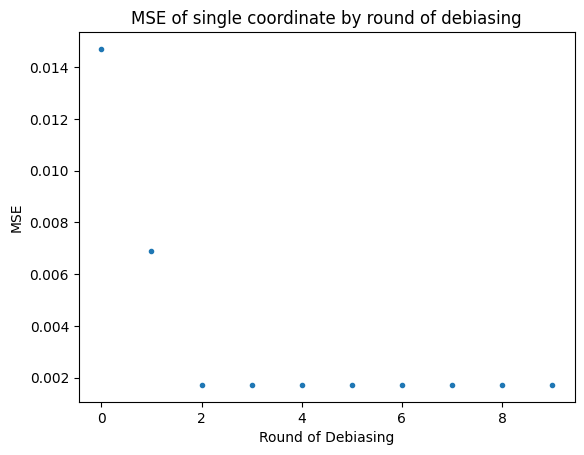

In [70]:
import debiasedModel
importlib.reload(debiasedModel)

import policies
import importlib 
importlib.reload(policies)

#this data is garbage but making just to have something to test the whole process with
n_rows = 5
n_features = 3
pred_dim = n_features 

xs = np.random.normal(size=(n_rows, n_features))
slopes = np.random.uniform(size = n_features)
errs = np.random.normal(scale=0.01, size = (n_rows, n_features))
ys = np.multiply(xs, slopes) + errs

# just predicts label mean
def h1(xs):
    # calculate label mean and duplicate it for each of xs
    return np.tile(np.average(ys, axis=0), (len(xs),1))
    

# second model predicts correct linear relationship for first stock and 0 everywhere else
def h2(xs):
    # build prediction 
    preds = np.zeros((len(xs), n_features))
    preds[:,0] = ys[:,0]
    return preds

init_model = h1
max_depth = 10
h1_policy = policies.Simplex(pred_dim, h1)
h2_policy = policies.Simplex(pred_dim, h2)

model = debiasedModel.Debiased_model()
model.debias(xs, ys, init_model, max_depth, h1_policy, h2_policy);

model.training_preds

mses = np.zeros((model.depth+1, model.prediction_dim))
for i in range(len(model.training_preds)):
    mses[i] = mse(ys, model.training_preds[i], multioutput='raw_values')

coord = 0
plt.plot(np.arange(model.depth+1), mses[:,coord], '.')
plt.title("MSE of single coordinate by round of debiasing")
plt.xlabel("Round of Debiasing")
plt.ylabel("MSE");

# init_model = h2

# model = debiasedModel.Debiased_model()
# model.debias(xs, ys, init_model, max_depth, policy);
# model.training_preds;

In [71]:

model.training_preds

[array([[-0.00386673, -0.03217463, -0.46391498],
        [-0.00386673, -0.03217463, -0.46391498],
        [-0.00386673, -0.03217463, -0.46391498],
        [-0.00386673, -0.03217463, -0.46391498],
        [-0.00386673, -0.03217463, -0.46391498]]),
 array([[ 0.13568037,  0.4272433 , -0.8709836 ],
        [ 0.13568037,  0.4272433 , -0.8709836 ],
        [-0.00386673, -0.03217463, -0.46391498],
        [-0.00386673, -0.03217463, -0.46391498],
        [-0.00386673, -0.03217463, -0.46391498]]),
 array([[ 0.13568037,  0.4272433 , -0.8709836 ],
        [ 0.13568037,  0.4272433 , -0.8709836 ],
        [-0.09689813, -0.33845325, -0.1925359 ],
        [-0.09689813, -0.33845325, -0.1925359 ],
        [-0.09689813, -0.33845325, -0.1925359 ]]),
 array([[ 0.13568037,  0.4272433 , -0.8709836 ],
        [ 0.13568037,  0.4272433 , -0.8709836 ],
        [-0.09689813, -0.33845325, -0.1925359 ],
        [-0.09689813, -0.33845325, -0.1925359 ],
        [-0.09689813, -0.33845325, -0.1925359 ]]),
 array([[ 0.

# Other Visualizations

Old code I'm keeping around so that I can reuse if needed.

[0.42144247 0.42144247 0.42144247 0.42144247 0.42144247]
[0.42144247 0.42144247 0.42144247 0.42144247 0.42144247]
[-0.34634243 -0.34634243 -0.34634243 -0.34634243 -0.34634243]
[-0.34634243 -0.34634243 -0.34634243 -0.34634243 -0.34634243]
[0.42144247 0.42144247 0.42144247 0.42144247 0.42144247]
[0.42144247 0.42144247 0.42144247 0.42144247 0.42144247]
[0.42144247 0.42144247 0.42144247 0.42144247 0.42144247]
[-0.34634243 -0.34634243 -0.34634243 -0.34634243 -0.34634243]
[0.42144247 0.42144247 0.42144247 0.42144247 0.42144247]
[-0.34634243 -0.34634243 -0.34634243 -0.34634243 -0.34634243]


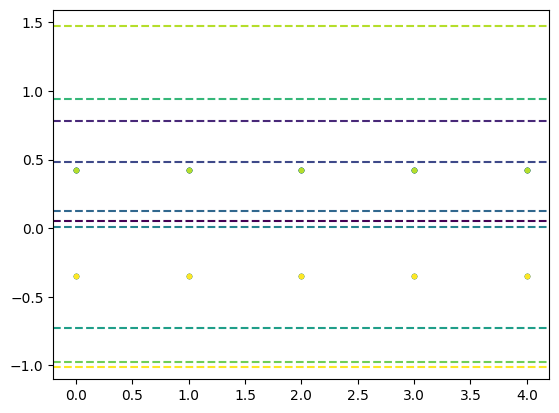

In [453]:
coord = 1

# color each of the datapoints 
num_colors = model.n 
color_palette = plt.cm.viridis(np.linspace(0, 1, num_colors))

# for each round, plot predictions on ith coordinate
preds = np.array(model.training_preds)
for i in range(model.n):
    # print(preds[np.arange(model.depth), i][:,coord])
    # Plot predictions
    plt.plot(np.arange(model.depth), preds[np.arange(model.depth), i][:,coord], '.', color=color_palette[i])
    # Plot the true values of each coordinate as a horizontal line
    plt.axhline(y=Y_train[i][coord], color=color_palette[i], linestyle='--', label='Horizontal Line at y=4');
